## IdentifyEmbeddingGroupings
This script:
- Loads the pickle file containing each sample point, the list of image files, the list of embeddings and the list of similarity scores
- Converts it so that each image (and associated embedding/scores) is its own row
- Removes some outlying images:
    - This stage may not be necessary, but does effectively remove images of both inside of buildings and inside of cars.
    - This is based on using UMAP to reduce the dimensionality of embeddings to 2, and then plotting in 2-dimensional space.
    There are two very clearly separated clusters of points which when I looked at the images within them, were those inside the cars and inside the buildings
- Cluster analysis:
    - Test whether there is a structure within the embeddings that would allow them to be broken down into sub-clusters
        - Silhouette scores (are scores higher than 1?)
        - Elbow scores
        - Adjusted Rand Index
    - Decide on the optimal K
    - Run a K-mean cluster analysis with optimal K

In [2]:
import pickle
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
# from functools import reduce
# from PIL import Image
import umap
import random
from functions import *

In [3]:
data_dir = os.path.join("../../../../data/embeddings/")
lsoas_file = os.path.join("../../../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")

### Get spatial data

In [4]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

### Get embeddings (four per location)

In [5]:
points_data_cache = data_dir + f"embeddings/points_data_cache_with_CLIP_embeddings_and_scores_planninguseclasses.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [6]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_lsoa, how='inner', predicate='within')

# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


# Expand dataframe so there is one row per image

In [7]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embedding']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths
    cat_scores = row['category_scores']        # list of 4 image paths
    
    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embedding, {len(images)} images")
        continue

    for score, emb, img in zip(cat_scores, embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embedding'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        new_row['category_scores'] = score
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)

Skipping row 9158: 3 embedding, 4 images
Skipping row 18664: 3 embedding, 4 images
Original rows: 18897, Expanded rows: 75580


# Remove inside cars and inside buildings images
This stage is potentially not necessary?

In [8]:
# Example wrapper if you have a dataframe
embeddings = np.vstack(expanded_gdf["embedding"].values)   # shape (N, 512)
             # string labels
reducer = umap.UMAP(
    n_neighbors=30, 
    min_dist=0.1, 
    metric='cosine',   # ✔ recommended for CLIP embeddings
    random_state=42)

emb_2d = reducer.fit_transform(embeddings)  # shape (N, 2)

expanded_gdf['umap_x'] = emb_2d[:, 0]
expanded_gdf['umap_y'] = emb_2d[:, 1]

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


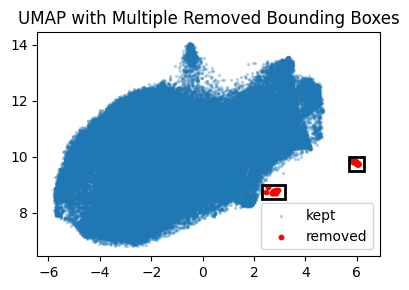

In [9]:
# ---------------------------------------------------------
# 2. Define MULTIPLE bounding boxes
#    Format: (x_min, x_max, y_min, y_max)
# ---------------------------------------------------------
bounding_boxes = [(5.7, 6.3, 9.5, 10),     # Box 1
                  (2.3, 3.2, 8.5,9)]

# ---------------------------------------------------------
# 3. Build mask for ANY point inside ANY box
# ---------------------------------------------------------
inside_any_box = np.zeros(len(expanded_gdf), dtype=bool)

for (x_min, x_max, y_min, y_max) in bounding_boxes:
    inside_this_box = (
        (expanded_gdf["umap_x"] >= x_min) & (expanded_gdf["umap_x"] <= x_max) &
        (expanded_gdf["umap_y"] >= y_min) & (expanded_gdf["umap_y"] <= y_max))
    inside_any_box |= inside_this_box      # combine masks

# ---------------------------------------------------------
# 4. Remove all points inside any bounding box
# ---------------------------------------------------------
expanded_gdf_filtered = expanded_gdf[~inside_any_box].copy()

# ---------------------------------------------------------
# 5. Visual sanity check
# ---------------------------------------------------------
plt.figure(figsize=(4, 3))

# Points kept
plt.scatter(expanded_gdf_filtered["umap_x"], expanded_gdf_filtered["umap_y"], s=2, alpha=0.25, label="kept")

# Points removed
plt.scatter(expanded_gdf.loc[inside_any_box, "umap_x"], expanded_gdf.loc[inside_any_box, "umap_y"], s=10, color="red",
            label="removed")

# Draw rectangles on the plot
ax = plt.gca()
for (x_min, x_max, y_min, y_max) in bounding_boxes:
    rect = plt.Rectangle((x_min, y_min),x_max - x_min,y_max - y_min,linewidth=2,edgecolor="black", facecolor="none")
    ax.add_patch(rect)

plt.legend()
plt.title("UMAP with Multiple Removed Bounding Boxes")
plt.tight_layout()
plt.show()

# (Optional) overwrite original:
expanded_gdf = expanded_gdf_filtered.copy()

## Save results

In [53]:
expanded_gdf.to_pickle(data_dir + f"embeddings/one_row_per_image_cleaned.pkl")

### Find mean embedding per LSOA

In [30]:
for col in ['geometry', 'GlobalID', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'umap_x', 'umap_y', 'LSOA21NM']:
    del expanded_gdf[col] 

In [43]:
# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)
emb_cat = expanded_gdf.groupby("LSOA21CD")["embedding"].apply(mean_embed).reset_index()
emb_cat.rename(columns={"embedding": "mean_embedding"}, inplace=True)

In [56]:
emb_cat.to_csv(data_dir + f"per_lsoa_embedding_summaries/mean_embedding.csv")